In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import cmath
from scipy.optimize import fsolve, minimize_scalar
import matplotlib.pyplot as plt

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'text.usetex': True,
           'image.cmap': 'seismic', 
           'figure.autolayout': True}
plt.rcParams.update(fparams)

# Pauli matrices
sx = np.array([[0, 1], [1, 0]], complex)
sy = np.array([[0 , -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]], complex)
s0 = np.array([[1, 0], [0, 1]], complex)

# 8x8 Identity matrix
eye = np.eye(8, dtype=complex)

np.seterr(all='raise', divide=None, over=None, under=None, invalid=None)

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Dimensionless parameters:

$$x = E/\Delta$$

$$y = B/\Delta$$

$$z = \alpha k_F/\Delta$$

In [2]:
def gap(y, z):
    energy = lambda q, s: np.sqrt(1 + q**2 + y**2 + z**2 + 2 * s * np.sqrt((1 + q**2) * y**2 + q**2 * z**2))
    gap_plus = minimize_scalar(lambda q: energy(q, 1))
    gap_minus = minimize_scalar(lambda q: energy(q, -1))
    return min(gap_plus.fun, gap_minus.fun)

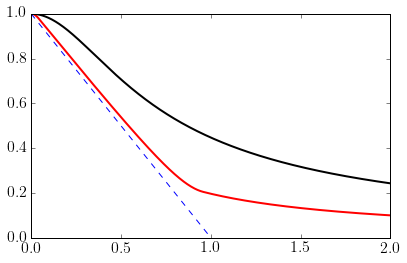

In [23]:
ys = np.linspace(0, 2, 500)
gaps = np.array([gap(y, 0.2) for y in ys])
gaps2 = np.array([gap(y, 0.5) for y in ys])
gaps3 = np.array([gap(y, 1e-10) for y in ys[:250]])
plt.plot(ys, gaps, c='r', lw=2)
plt.plot(ys, gaps2, c='k', lw=2)
plt.plot(ys[:250], gaps3, c='b', lw=1, ls='--')

In [4]:
def x_c(y, z):
    return np.sqrt(z**2 / (z**2 + y**2))

def z_c(y):
    return np.sqrt(y*(1-y))

def pole(x, y, z, sign=-1, tple=False):
    pol = cmath.sqrt(-1 + x**2 + y**2 + z**2 + 2 * 1j * sign * cmath.sqrt(z**2 * (1 - x**2) - x**2 * y**2))
    if tple:
        return (pol.real, pol.imag)
    else:
        return pol

## Evolution of the poles in the complex plane

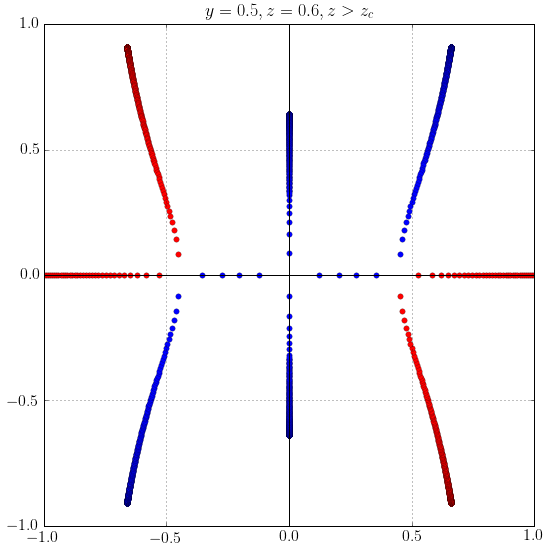

In [5]:
y = 0.5
z = 0.6
xs = np.linspace(0, 2*x_c(y, z), 500)
q0s = [pole(x, y, z, sign=-1, tple=True) for x in xs]
q1s = [pole(x, y, z, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(zip(*q0s))
req1, imq1 = np.array(zip(*q1s))
plt.figure(figsize=(8,8))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='r', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='b', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title(r'$y=0.5, z=0.6, z>z_c$')

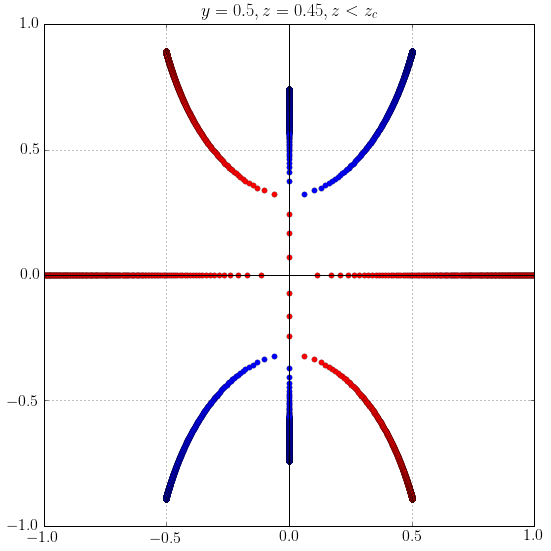

In [6]:
y = 0.5
z = 0.45
xs = np.linspace(0, 2*x_c(y,z), 1000)
q0s = [pole(x, y, z, sign=-1, tple=True) for x in xs]
q1s = [pole(x, y, z, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(zip(*q0s))
req1, imq1 = np.array(zip(*q1s))
plt.figure(figsize=(8,8))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='r', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='b', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title(r'$y=0.5, z=0.45, z<z_c$')

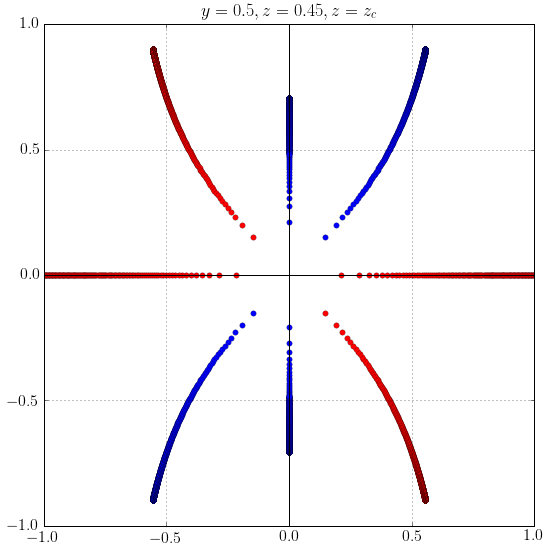

In [7]:
y = 0.5
z = 0.5
xs = np.linspace(0, 2*x_c(y,z), 1000)
q0s = [pole(x, y, z, sign=-1, tple=True) for x in xs]
q1s = [pole(x, y, z, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(zip(*q0s))
req1, imq1 = np.array(zip(*q1s))
plt.figure(figsize=(8,8))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='r', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='b', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title(r'$y=0.5, z=0.45, z=z_c$')

In [8]:
def limit(y, z):
    # Takes care of limit to avoid division by zero:
    if y==0 and not z==0:
        z, s = 1, 1
    elif z==0 and not y==0:
        y, s = 1, 1
    elif z==0 and y==0:
        s = 1
    else:
        s = np.sqrt(y**2 + z**2)
    return s, y, z
    

def a(x, y, z):
    s = np.sqrt(y**2 + z**2)
    a = x * (1 - x**2 + y**2 + z**2) * eye
    a -= 2 * x * y * np.kron(sx, np.kron(s0, sx))
    a -= 2 * y * z * np.kron(s0, np.kron(sz, sx)) / s
    a += z * (1 - x**2 + y**2 + z**2) * np.kron(sx, np.kron(sz, s0)) / s
    a += y * (1 - x**2 - y**2 - z**2) * np.kron(sy, np.kron(s0, sy)) / s
    a += (y**2 * (1 + x**2 - 2 * z**2 - y**2) - z**2 * (1 - x**2 + z**2)) * np.kron(sz, np.kron(s0, sz)) / s
    return a


def c(x, y, z):
    s = np.sqrt(y**2 + z**2)
    c = x * eye
    c += z * np.kron(sx, np.kron(sz, s0)) / s
    c += y * np.kron(sy, np.kron(s0, sy)) / s
    c += s * np.kron(sz, np.kron(s0, sz))
    return c


def g(x, y, z, q0):
    g = - 0.5 * ((q0 - np.conj(q0)) * np.kron(sz, np.kron(sz, s0)))
    g -= 0.5 * (c(x, y, z) + a(x, y, z) / np.abs(q0)**2)
    return g


def T(tau, y, z):
    s = np.sqrt(y**2 + z**2)
    r = np.sqrt(1 - tau) / np.sqrt(tau)
    T = eye - 1j * r * np.kron(s0, np.kron(sz, s0))
    T += z * r * np.kron(sz, np.kron(sx, sy)) / s
    T += y * r * np.kron(s0, np.kron(sy, s0)) / s
    return T

In [9]:
def bound_state_determinant(x, y, z, tau, phi, tol=1e-6):
    q0 = pole(x, y, z)
    phiexp = np.cos(0.5 * phi) * eye - 1j *  np.sin(0.5 * phi) * np.kron(sz, np.kron(s0, s0))
    tfactor = np.dot(phiexp, T(tau, y, z)) - eye
    gfactor = np.dot(g(x, y, z, q0), np.kron(sz, np.kron(sz, s0)))
    m = (q0 - np.conj(q0)) * eye - np.dot(gfactor, tfactor)
    mdet = np.linalg.det(m)
    #if np.max(mdet.imag) > tol:
    #    raise Warning("The imaginary part of the determinant is greater than %s" % tol)
    return mdet.real

In [10]:
def func(xs, p):
    D = gap(p.y, p.z)
    domain = lambda x : ((x > 0) & (x < D))
    vals = np.array([bound_state_determinant(x, p.y, p.z, p.tau, p.phi) if domain(x) else 1000 + 10*abs(x) for x in xs])
    return vals

In [11]:
p = SimpleNamespace(y = 0., z = 0.6, tau = 0.7, phi=np.pi)

In [12]:
np.sqrt(1-p.tau)

0.54772255750516619

In [13]:
sol = fsolve(lambda x: func(x, p), [np.sqrt(1-p.tau)-0.3, np.sqrt(1-p.tau)+0.3], full_output=1)

In [15]:
sol[0][0]

0.54772256451512236

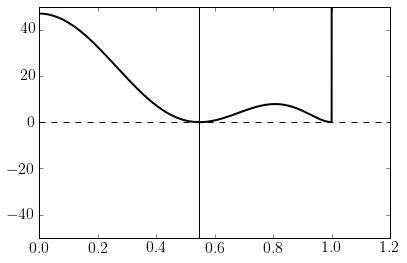

In [16]:
#Simple test of the root finding
xs = np.linspace(1e-6, 1.2, 300)
plt.plot(xs, func(xs, p), c='k', lw=2)
plt.axhline(0, c='k', ls='--')
plt.ylim(-50, 50)
plt.axvline(sol[0][0], c='r')
plt.axvline(sol[0][1], c='k')

## Splitting at finite z

In [20]:
p = SimpleNamespace(y=0., z=0.6, tau=0.7, phi=np.pi)
ys = np.linspace(1e-4, 2, 150)
solutions = []
x0 = [np.sqrt(1-p.tau)+0.01, np.sqrt(1-p.tau)-0.01]
for y in ys:
    p.y = y
    sol = fsolve(lambda x: func(x, p), x0, full_output=1)
    x0 = [min(sol[0][0], gap(p.y, p.z)), max(sol[0][1], 0.01)]
    solutions.append(sol)
vals = np.array(zip(*[s[0] for s in solutions]))

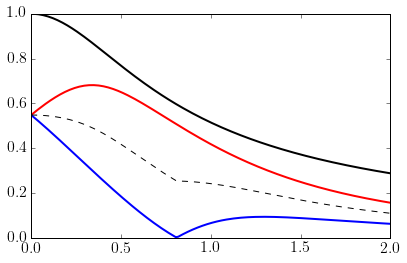

In [22]:
plt.plot(ys, vals[0], c='r', lw=2)
plt.plot(ys, vals[1], c='b', lw=2)
plt.plot(ys, (vals[1]+vals[0])/2, c='k', lw=1, ls='--')
plt.plot(ys, np.sqrt(p.z**2 / (ys**2 + p.z**2)), c='k', lw=2)